In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
import json
import os 
import tensorflow as tf
import sklearn
import seaborn as sbs
import sklearn.naive_bayes 
import sklearn.model_selection
import sklearn.metrics

In [2]:
tf.__version__

'2.1.0'

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

/kaggle/input/kernel61a3716833/tokenization.py
/kaggle/input/kernel61a3716833/__results__.html
/kaggle/input/kernel61a3716833/model_best.hdf5
/kaggle/input/kernel61a3716833/__notebook__.ipynb
/kaggle/input/kernel61a3716833/custom.css
/kaggle/input/kernel61a3716833/model.h5
/kaggle/input/kernel61a3716833/__output__.json
/kaggle/input/kernel61a3716833/__results___files/__results___8_1.png
/kaggle/input/kernel61a3716833/__results___files/__results___10_2.png
/kaggle/input/kernel61a3716833/__results___files/__results___7_1.png
/kaggle/input/kernel61a3716833/__pycache__/tokenization.cpython-37.pyc
/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv
/kaggle/input/fasttext-crawl-300d-2m/crawl-300d-2M.vec
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json


In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Blues) :
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

F1 score function

In [5]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

def plot_roc(fpr,tpr,label= 'ROC curve'):
    plt.plot(fpr, tpr, label = 'ROC curve', linewidth = 2)
    plt.plot([0,1],[0,1], 'k--', linewidth = 2)
   # plt.xlim([0.0,0.001])
   # plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show();

In [6]:
df1 = pd.read_json("/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json", lines=True)
df2 = pd.read_json("/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json", lines=True)
df = pd.concat([df1[['headline', 'is_sarcastic']],df2[['headline', 'is_sarcastic']]], axis=0)
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [7]:
temp1 = df1['headline'].apply(lambda x : len(x.split()))
print(max(temp1))
temp = df2['headline'].apply(lambda x : len(x.split()))
print(max(temp))

39
151


In [8]:
import warnings
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
trace = go.Pie(labels = ['Non Sarcastic','Sarcastic'], values = df['is_sarcastic'].value_counts(), 
               textfont=dict(size=15), opacity = 0.8,
               marker=dict(colors=['lightskyblue', 'gold'], 
                           line=dict(color='#000000', width=1.5)))


layout = dict(title =  'Distribution of data')
           
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

(array([1.170e+02, 3.040e+02, 5.790e+02, 1.141e+03, 1.727e+03, 2.347e+03,
        2.853e+03, 3.302e+03, 3.486e+03, 3.197e+03, 2.644e+03, 1.863e+03,
        1.282e+03, 0.000e+00, 7.940e+02, 4.380e+02, 2.850e+02, 1.670e+02,
        8.100e+01, 3.900e+01, 2.600e+01, 1.400e+01, 8.000e+00, 4.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([ 2.   ,  2.925,  3.85 ,  4.775,  5.7  ,  6.625,  7.55 ,  8.475,
         9.4  , 10.325, 11.25 , 12.175, 13.1  , 14.025, 14.95 , 15.875,
        16.8  , 17.725, 18.65 , 19.575, 20.5  , 21.425, 22.35 , 23.275,
        24.2  , 25.125, 26.05 , 26.975, 27.9  , 28.825, 29.75 , 30.675,
        31.6  , 32.525, 33.45 , 34.375, 35.3  , 36.225, 37.15 , 38.075,
        39.   ]),
 <a list of 40 Patch objects>)

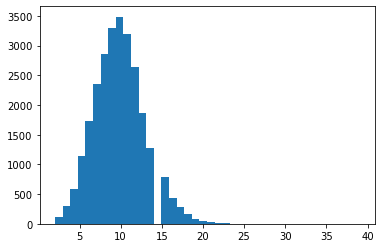

In [9]:
plt.hist(temp1, bins=40)

(array([1.180e+02, 3.060e+02, 5.910e+02, 1.164e+03, 1.762e+03, 2.404e+03,
        2.935e+03, 3.425e+03, 3.638e+03, 3.396e+03, 2.841e+03, 2.083e+03,
        1.492e+03, 9.690e+02, 5.780e+02, 3.830e+02, 2.280e+02, 1.430e+02,
        6.300e+01, 4.500e+01, 2.300e+01, 1.200e+01, 5.000e+00, 2.000e+00,
        1.000e+00, 3.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

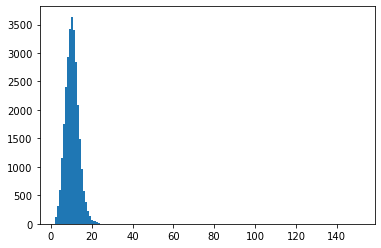

In [10]:
plt.hist(temp, bins=150)

In [12]:
print (df['is_sarcastic'].value_counts())

0    29970
1    25358
Name: is_sarcastic, dtype: int64


Vocabulary size 30884


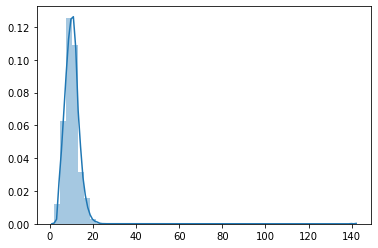

In [13]:
vocab_size = 30000  # There are 30884 words in total
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df.headline)
print("Vocabulary size", len(tokenizer.word_index))

train_inputs = tokenizer.texts_to_sequences(df.headline)
sbs.distplot([len(l) for l in train_inputs])

In [35]:
train_inputs = tf.keras.preprocessing.sequence.pad_sequences(train_inputs, padding='post', maxlen=20)
train_labels = df['is_sarcastic']

# Split data into train /validation 
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(train_inputs, train_labels, 
                                                                          test_size=0.2, random_state=0)
train_inputs[0]

array([  314, 15932,   642,  3417,  2441,    45,   386,  2721, 15933,
           5,  2722,  8922,     0,     0,     0,     0,     0,     0,
           0,     0], dtype=int32)

In [36]:
max_len = 20
text_input = tf.keras.Input(shape=(max_len, ))
embed_text = tf.keras.layers.Embedding(vocab_size, 128)(text_input)

net = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(embed_text)
net = tf.keras.layers.Dropout(0.4)(net)
net = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(net)
net = tf.keras.layers.GlobalMaxPool1D()(net)
net = tf.keras.layers.Dense(64, activation='relu')(net)
net = tf.keras.layers.Dropout(0.4)(net)
net = tf.keras.layers.Dense(32, activation='relu')(net)
net = tf.keras.layers.Dropout(0.4)(net)

output = tf.keras.layers.Dense(1, activation='sigmoid')(net)
model = tf.keras.models.Model(text_input, output)
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 20, 128)           3840000   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 20, 128)           98816     
_________________________________________________________________
dropout_15 (Dropout)         (None, 20, 128)           0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 20, 64)            41216     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                4160

In [37]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

mc = tf.keras.callbacks.ModelCheckpoint('model_best_twolstm.hdf5', monitor='val_accuracy', 
                                        verbose=1, save_best_only=True, mode='max')
es = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=5)
    
history = model.fit(X_train, y_train,
                    epochs=30, batch_size=256, callbacks=[mc, es], 
                    validation_split=0.1, verbose=1)

Train on 39835 samples, validate on 4427 samples
Epoch 1/30
39680/39835 [============================>.] - ETA: 0s - loss: 0.4020 - accuracy: 0.8041
Epoch 00001: val_accuracy improved from -inf to 0.91665, saving model to model_best_twolstm.hdf5
39835/39835 [==============================] - 27s 680us/sample - loss: 0.4013 - accuracy: 0.8045 - val_loss: 0.2213 - val_accuracy: 0.9166
Epoch 2/30
39680/39835 [============================>.] - ETA: 0s - loss: 0.1384 - accuracy: 0.9546
Epoch 00002: val_accuracy improved from 0.91665 to 0.93653, saving model to model_best_twolstm.hdf5
39835/39835 [==============================] - 20s 499us/sample - loss: 0.1386 - accuracy: 0.9545 - val_loss: 0.1912 - val_accuracy: 0.9365
Epoch 3/30
39680/39835 [============================>.] - ETA: 0s - loss: 0.0661 - accuracy: 0.9800
Epoch 00003: val_accuracy improved from 0.93653 to 0.94104, saving model to model_best_twolstm.hdf5
39835/39835 [==============================] - 20s 498us/sample - loss: 0.

In [38]:
import sklearn
import sklearn.metrics
# model = tf.keras.models.load_model('/kaggle/input/kernel61a3716833/model_best.hdf5')
y_score = model.predict(X_val, batch_size=1024)
y_preds = model.predict(X_val, batch_size=1024).round().astype(int)

In [39]:
y_score

array([[9.9999988e-01],
       [1.0000000e+00],
       [2.7022747e-07],
       ...,
       [9.9999917e-01],
       [5.1274378e-07],
       [1.3061181e-07]], dtype=float32)

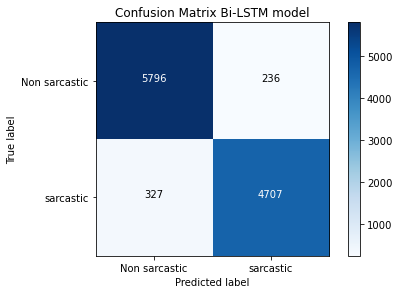

In [40]:
import matplotlib.pyplot as plt   
import itertools
cm=sklearn.metrics.confusion_matrix(y_val, y_preds)
plot_confusion_matrix(cm,classes=['Non sarcastic','sarcastic'],title='Confusion Matrix Bi-LSTM model')

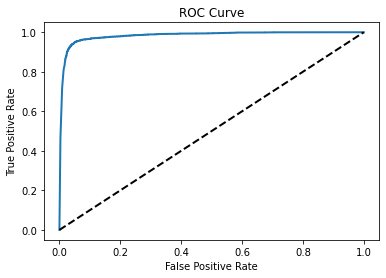

In [41]:
fpr, tpr, t = sklearn.metrics.roc_curve(y_val, y_score)
plot_roc(fpr, tpr,label='ROC curve: Bi-LSTM model ')

In [42]:
print("Test accuracy score", sklearn.metrics.accuracy_score(y_val, y_preds))
print('Precision= ',sklearn.metrics.precision_score(y_val, y_preds))
print('Recall= ',sklearn.metrics.recall_score(y_val, y_preds))
print('F1 score= ',sklearn.metrics.f1_score(y_val, y_preds))
from sklearn.metrics import roc_auc_score
print('auc= ',roc_auc_score(y_val,y_score))

Test accuracy score 0.9491234411711549
Precision=  0.9522557151527412
Recall=  0.935041716328963
F1 score=  0.9435702114864187
auc=  0.982550947983421


# Sarcasm detection with Bert

In [21]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [22]:
import tensorflow_hub as hub 
import tokenization

module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [23]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [24]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    net = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(32, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(net)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [25]:
max_len = 100
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(df.headline, df['is_sarcastic'], 
                                                                          test_size=0.1, random_state=0)
X_train = bert_encode(X_train, tokenizer, max_len=max_len)
X_val = bert_encode(X_val, tokenizer, max_len=max_len)
model = build_model(bert_layer, max_len=max_len)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [ ]:
%%time
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

train_history = model.fit(
    X_train, y_train, 
    validation_split=0.1,
    epochs=30,
    callbacks=[checkpoint, earlystopping],
    batch_size=16,
    verbose=1
)

In [26]:
%%time
model.load_weights('/kaggle/input/kernel61a3716833/model.h5')
y_score = model.predict(X_val, batch_size=1024)
y_preds = model.predict(X_val, batch_size=1024).round().astype(int)

CPU times: user 1h 56min 33s, sys: 13min 17s, total: 2h 9min 51s
Wall time: 34min 13s


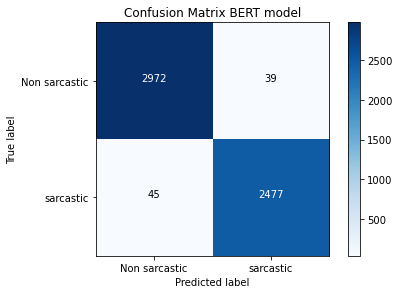

In [27]:
import matplotlib.pyplot as plt   
import itertools
cm=sklearn.metrics.confusion_matrix(y_val, y_preds)
plot_confusion_matrix(cm,classes=['Non sarcastic','sarcastic'],title='Confusion Matrix BERT model')

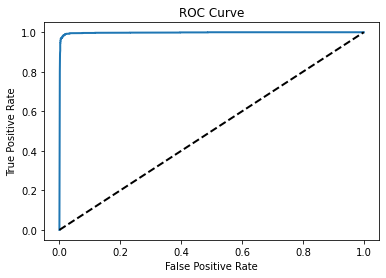

In [28]:
fpr, tpr, t = sklearn.metrics.roc_curve(y_val, y_score)
plot_roc(fpr, tpr,label='ROC curve: BERT model ')

In [29]:
print("Test accuracy score", sklearn.metrics.accuracy_score(y_val, y_preds))
print('Precision= ',sklearn.metrics.precision_score(y_val, y_preds))
print('Recall= ',sklearn.metrics.recall_score(y_val, y_preds))
print('F1 score= ',sklearn.metrics.f1_score(y_val, y_preds))
from sklearn.metrics import roc_auc_score
print('auc= ',roc_auc_score(y_val,y_score))

Test accuracy score 0.984818362551961
Precision=  0.9844992050874404
Recall=  0.9821570182394924
F1 score=  0.983326716951171
auc=  0.9975255941010375
